In [139]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster as sklc
import sklearn.metrics as sklm

In [ ]:
lsoa = gpd.read_file("data/boundaries/LSOA_2004_London_Low_Resolution.shp")

In [ ]:
la = lsoa.dissolve(by="LA_NAME")

## Hotels Data

In [3]:
osm = gpd.read_file("data/hotel/gis_osm_pois_a_free_1.shp")

In [8]:
hotel = osm[osm["fclass"] == "hotel"]

In [13]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
hotel = hotel.to_crs(lsoa.crs)

In [15]:
#Spatially joining the LSOA to each listing
lsoa_h = hotel.sjoin(lsoa, predicate="within")

In [17]:
#Number of hotels by LSOA
lsoa_h["count"] = 1
hotel_count = lsoa_h.groupby("LSOA_CODE")["count"].sum().reset_index()
#hotel_count

,LSOA_CODE,count
0,E01000004,16
1,E01000005,5
2,E01000010,2
3,E01000036,1
4,E01000047,3
...,...,...
378,E01004761,18
379,E01004762,7
380,E01004763,7
381,E01004764,7


In [27]:
lsoa_hotels = lsoa.merge(hotel_count, on="LSOA_CODE", how= "left")

In [33]:
lsoa_hotels['count'] = lsoa_hotels['count'].fillna(0)


In [58]:
lsoa_hotels = lsoa_hotels.rename(columns={"count": "hotel_count"})

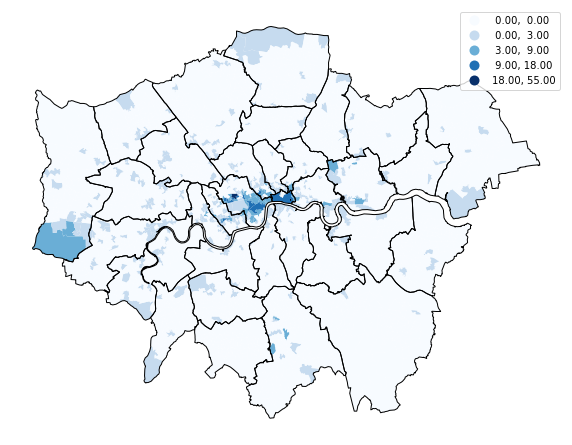

In [46]:
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_hotels.plot(column = "hotel_count", scheme="fisher_jenks", cmap="Blues", ax=ax, legend=True)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax)

plt.axis("off")

plt.show()

## AirBnB Data

In [48]:
# Reading in listings data
listings = gpd.read_feather("data/2022-09-10-listings.geofeather")

In [49]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
listings = listings.to_crs(lsoa.crs)

In [50]:
#Spatially joining the LSOA to each listing
lsoa_ls = listings.sjoin(lsoa, predicate="within")

In [51]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_ls["count"] = 1
airbnb_count = lsoa_ls.groupby("LSOA_CODE")["count"].sum().reset_index()
#airbnb_count

,LSOA_CODE,count
0,E01000001,14
1,E01000002,8
2,E01000003,19
3,E01000004,257
4,E01000005,120
...,...,...
4394,E01004761,213
4395,E01004762,95
4396,E01004763,371
4397,E01004764,287


In [60]:
airbnb_count = airbnb_count.rename(columns={"count":"airbnb_count"})

In [61]:
lsoa_hotels_airbnb = lsoa_hotels.merge(airbnb_count, on="LSOA_CODE", how= "left")

In [64]:
lsoa_hotels_airbnb['airbnb_count'] = lsoa_hotels_airbnb['airbnb_count'].fillna(0)

## Culture data

In [76]:
culture = pd.read_csv('data/cultural-infrastructure-map-all-sites.csv')


In [77]:
culture = culture.rename(columns = {'Cultural Venue Type':'venue_type'})


In [78]:
#Convert to spatial object (geopandas)
gdf_culture = gpd.GeoDataFrame(culture, 
                               geometry=gpd.points_from_xy(culture.longitude, culture.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf_culture = gdf_culture.to_crs(lsoa.crs)

In [79]:
lsoa_culture = gdf_culture.sjoin(lsoa, predicate="within")

In [82]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_culture["count"] = 1
culture_count = lsoa_culture.groupby("LSOA_CODE")["count"].sum().reset_index()

In [84]:
culture_count = culture_count.rename(columns={"count":"culture_count"})

In [91]:
lsoa_hotels_airbnb_culture = lsoa_hotels_airbnb.merge(culture_count, on="LSOA_CODE", how= "left")

In [92]:
lsoa_hotels_airbnb_culture['culture_count'] = lsoa_hotels_airbnb_culture['culture_count'].fillna(0)

## Density for each variable

In [112]:
lsoa_hotels_airbnb_culture['culture_density'] = lsoa_hotels_airbnb_culture["culture_count"] / lsoa_hotels_airbnb_culture.area * 1e6
lsoa_hotels_airbnb_culture['hotel_density'] = lsoa_hotels_airbnb_culture["hotel_count"] / lsoa_hotels_airbnb_culture.area * 1e6
lsoa_hotels_airbnb_culture['airbnb_density'] = lsoa_hotels_airbnb_culture["airbnb_count"] / lsoa_hotels_airbnb_culture.area * 1e6

In [113]:
lsoa_hotels_airbnb_culture

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,hotel_count,airbnb_count,culture_count,culture_density,hotel_density,airbnb_density
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,14.0,12.0,90.093298,0.000000,105.108848
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,8.0,26.0,115.132574,0.000000,35.425408
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,19.0,4.0,68.637732,0.000000,326.029226
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18...",16.0,257.0,275.0,119.682815,6.963364,111.849031
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((533378.878 181459.767, 533439.561 18...",5.0,120.0,22.0,114.155605,25.944456,622.666936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,E01004761,Westminster 018D,E02000977,Westminster 018,00BKGW,West End,00BK,Westminster,"POLYGON ((528459.247 180541.840, 528440.441 18...",18.0,213.0,49.0,94.495877,34.712771,410.767790
4761,E01004762,Westminster 011E,E02000970,Westminster 011,00BKGW,West End,00BK,Westminster,"POLYGON ((528043.878 180619.098, 527888.747 18...",7.0,95.0,15.0,50.757819,23.686982,321.466188
4762,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((529156.425 181706.116, 529157....",7.0,371.0,127.0,434.720532,23.960974,1269.931632
4763,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",7.0,287.0,152.0,243.303276,11.204756,459.395001


Example map

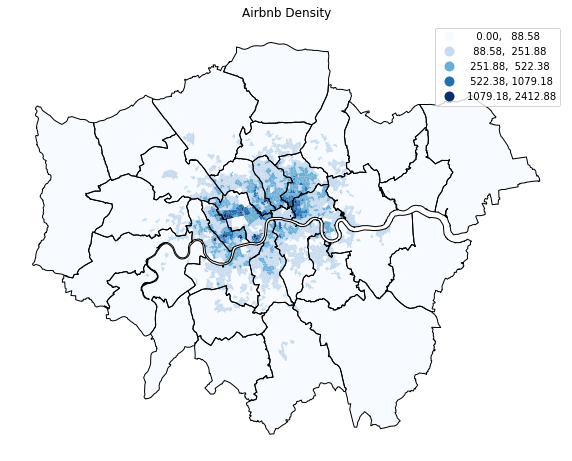

In [115]:
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_hotels_airbnb_culture.plot(column = "airbnb_density", scheme="fisher_jenks", cmap="Blues", ax=ax, legend=True)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax)

plt.axis("off")

plt.title("Airbnb Density")

plt.show()

## Standardisation of data

In [119]:
columns = ['culture_density', 'hotel_density', 'airbnb_density']

In [121]:
mms = MinMaxScaler()
data_standardised = lsoa_hotels_airbnb_culture.copy()
for c in columns:
    data_standardised[c] = mms.fit_transform(lsoa_hotels_airbnb_culture[c].values.reshape(-1,1))

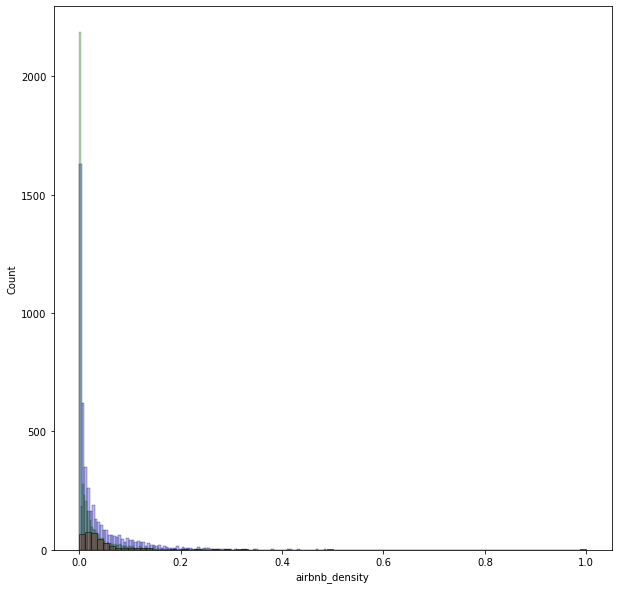

In [136]:
fig, ax = plt.subplots(1, figsize=(10,10))

sns.histplot(data = data_standardised, x="airbnb_density", ax=ax, label="Airbnb", color="b", alpha=0.3)
sns.histplot(data = data_standardised[data_standardised["hotel_density"] > 0], x="hotel_density",  label="Hotel", color="r", alpha=0.3)
sns.histplot(data = data_standardised, x="culture_density", ax=ax, label="Culture", color="g", alpha=0.3)

plt.show()

In [161]:
# we fix the random_state so that the kmeans result is reproducible
random_state_seed = 100
num_clusters = 5

kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(data_standardised[columns])

# Sanity check
print(kmeans_output)

# This line creates a list giving the final cluster ID of each point:
clustering_ids_kmeans = kmeans_output.labels_

# You can print the clustering IDs to get an ordered list of labels
print(clustering_ids_kmeans)

KMeans(n_clusters=5, random_state=100)
[4 4 4 ... 0 0 0]


In [162]:
data = data_standardised.assign(cluster_id = clustering_ids_kmeans)


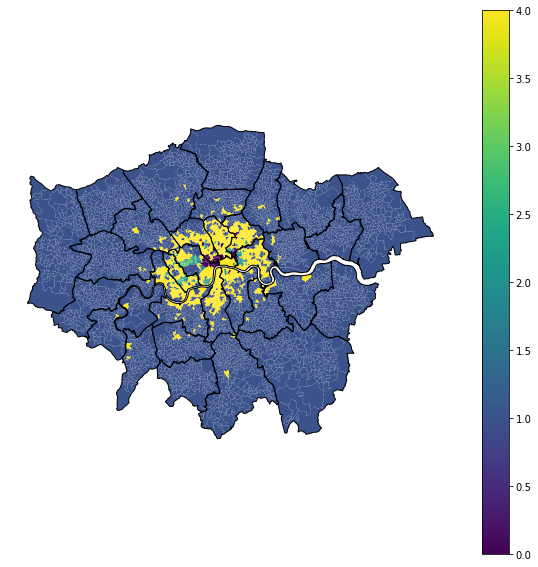

In [163]:
fig, ax = plt.subplots(1, figsize=(10,10))

data.plot(column = "cluster_id", ax=ax, legend=True, k=5)
la.plot(color="none", edgecolor="black", linewidth=1, ax=ax)

plt.axis("off")


plt.savefig("figures/clusters_map.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

In [183]:
data.head()

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,hotel_count,airbnb_count,culture_count,culture_density,hotel_density,airbnb_density,cluster_id
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,14.0,12.0,0.207244,0.000000,0.043562,4
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,8.0,26.0,0.264843,0.000000,0.014682,4
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,19.0,4.0,0.157889,0.000000,0.135120,4
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18...",16.0,257.0,275.0,0.275310,0.033451,0.046355,4
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((533378.878 181459.767, 533439.561 18...",5.0,120.0,22.0,0.262595,0.124634,0.258060,2


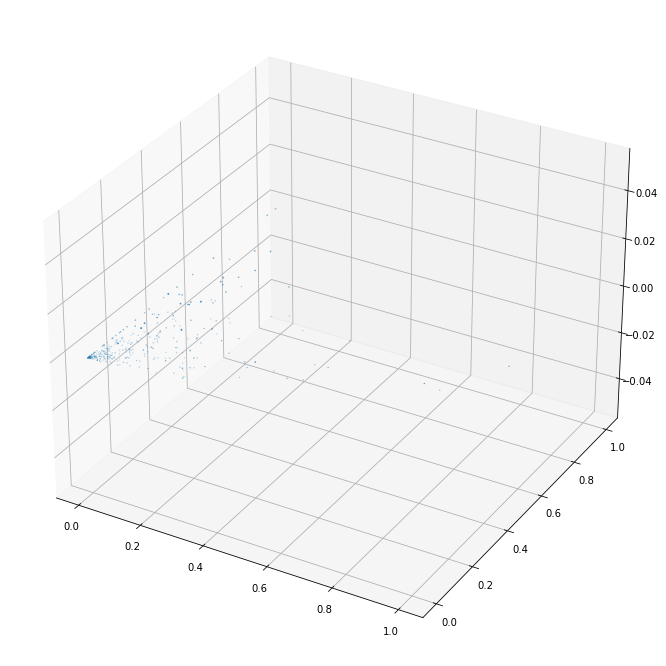

In [196]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

plt.scatter(data = data, x= "culture_density", y = "airbnb_density", s = "hotel_density")
plt.show()

In [182]:
data.groupby("cluster_id")[["hotel_density", "airbnb_density","culture_density"]].median()

,hotel_density,airbnb_density,culture_density
cluster_id,,,
0,0.013251,0.217591,0.386425
1,0.000000,0.007226,0.000000
2,0.034670,0.262918,0.079211
3,0.578134,0.534428,0.081529
4,0.000000,0.104130,0.059524


In [177]:
clusters_data = data.groupby("cluster_id")[["hotel_density", "airbnb_density","culture_density"]].mean()
clusters_data

,hotel_density,airbnb_density,culture_density
cluster_id,,,
0,0.037369,0.253694,0.442512
1,0.001034,0.014831,0.009137
2,0.071991,0.312300,0.093400
3,0.636146,0.546865,0.072227
4,0.006166,0.108758,0.070689



|  Cluster ID| Description (Hotel, AirBnB, Culture) |
| --- | --- | 
| 0 |Low - Mid -High |
| 1 | Low - Low - Low |
| 2 | Mid - high - Mid|
| 3 | High - High - Mid |
| 4 | Low - Mid - Mid|

<AxesSubplot:ylabel='cluster_id'>

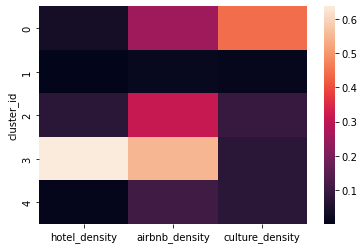

In [198]:
sns.heatmap(clusters_data, )

In [179]:
clusters_data.rank()

,hotel_density,airbnb_density,culture_density
cluster_id,,,
0,3.0,3.0,5.0
1,1.0,1.0,1.0
2,4.0,4.0,4.0
3,5.0,5.0,3.0
4,2.0,2.0,2.0


In [168]:
silhouette_kmeans = sklm.silhouette_score(data_standardised[columns],clustering_ids_kmeans)


print("Silhouette Score:", silhouette_kmeans)


Silhouette Score: 0.6696018553779441


.
.
.
.
.
.
.
.
.
.
.
.
.
.
Largest silhouette score was 0.7809 for k=2


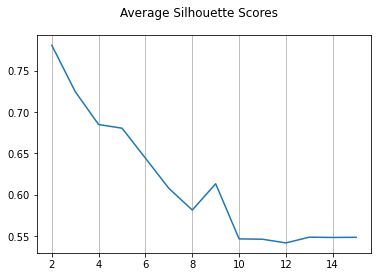

In [176]:
x = []
y = []
# For resolutions of 'k' in the range 2..40
for k in range(2,16):
    #############
    # Do the clustering using the main columns
    kmeans = sklc.KMeans(n_clusters=k, n_init=25, random_state=42).fit(X)
    # Calculate the overall silhouette score
    silhouette_avg = sklm.silhouette_score(X, kmeans.labels_)
    y.append(k)
    x.append(silhouette_avg)
    print('.', end='')
    print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")
plt.plot(y, x)
plt.gca().xaxis.grid(True);
plt.gcf().suptitle("Average Silhouette Scores");